In [ ]:
# ============================================================
# AUTOENCODER vs VARIATIONAL AUTOENCODER COMPARISON
# ============================================================

# ============================================================
# 🔧 CONFIGURATION
# ============================================================
import os, random, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "text.latex.preamble": r"\usepackage{amsmath}",  # <-- add this
})
config = {
    "image_folder": "../../../SparseSamplingCS-AE-RL/data/faces/ai/",
    "image_size": 128,
    "batch_size": 32,
    "epochs": 10,
    "learning_rate": 1e-3,
    "latent_dim": 128,
    "train_split": 0.7,
    "val_split": 0.15,
    "num_workers": 2,
    "seed": 42
}

# ============================================================
# DEVICE SETUP
# ============================================================
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
random.seed(config["seed"])

# ============================================================
# DATA
# ============================================================
transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(config["image_folder"], transform=transform)
n_total = len(dataset)
n_train = int(config["train_split"] * n_total)
n_val = int(config["val_split"] * n_total)
n_test = n_total - n_train - n_val
train_data, val_data, test_data = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True, num_workers=config["num_workers"])
val_loader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=False, num_workers=config["num_workers"])
test_loader = DataLoader(test_data, batch_size=config["batch_size"], shuffle=False, num_workers=config["num_workers"])

print(f"Train: {n_train}, Val: {n_val}, Test: {n_test}")

# ============================================================
# BASE CONVOLUTIONAL ENCODER / DECODER
# ============================================================
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(True)
        )
    def forward(self, x):
        return self.layers(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

# ============================================================
# MODELS: AE and VAE
# ============================================================
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, x):
        return self.decoder(self.encoder(x))

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = Encoder()
        enc_out_dim = 128 * (config["image_size"] // 8) ** 2
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(enc_out_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, enc_out_dim)
        self.decoder = Decoder()
    def encode(self, x):
        h = self.encoder(x).flatten(start_dim=1)
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 128, config["image_size"] // 8, config["image_size"] // 8)
        return self.decoder(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# ============================================================
# LOSS FUNCTIONS
# ============================================================
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kld) / x.size(0)

# ============================================================
# TRAIN BOTH MODELS
# ============================================================
ae, vae = Autoencoder().to(device), VAE(latent_dim=config["latent_dim"]).to(device)
opt_ae = optim.Adam(ae.parameters(), lr=config["learning_rate"])
opt_vae = optim.Adam(vae.parameters(), lr=config["learning_rate"])
criterion = nn.MSELoss()

ae_train, ae_val, vae_train, vae_val = [], [], [], []

for epoch in range(config["epochs"]):
    # ---- AE ----
    ae.train(); total_loss = 0
    for imgs,_ in train_loader:
        imgs = imgs.to(device)
        recon = ae(imgs)
        loss = criterion(recon, imgs)
        opt_ae.zero_grad(); loss.backward(); opt_ae.step()
        total_loss += loss.item() * imgs.size(0)
    ae.train_loss = total_loss / len(train_loader.dataset)
    ae_val_loss = 0
    ae.eval()
    with torch.no_grad():
        for imgs,_ in val_loader:
            imgs = imgs.to(device)
            loss = criterion(ae(imgs), imgs)
            ae_val_loss += loss.item() * imgs.size(0)
    ae_val_loss /= len(val_loader.dataset)
    ae_train.append(ae.train_loss); ae_val.append(ae_val_loss)

    # ---- VAE ----
    vae.train(); total_loss = 0
    for imgs,_ in train_loader:
        imgs = imgs.to(device)
        recon, mu, logvar = vae(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)
        opt_vae.zero_grad(); loss.backward(); opt_vae.step()
        total_loss += loss.item() * imgs.size(0)
    vae.train_loss = total_loss / len(train_loader.dataset)
    vae_val_loss = 0
    vae.eval()
    with torch.no_grad():
        for imgs,_ in val_loader:
            imgs = imgs.to(device)
            recon, mu, logvar = vae(imgs)
            loss = vae_loss(recon, imgs, mu, logvar)
            vae_val_loss += loss.item() * imgs.size(0)
    vae_val_loss /= len(val_loader.dataset)
    vae_train.append(vae.train_loss); vae_val.append(vae_val_loss)

    print(f"Epoch {epoch+1}/{config['epochs']} | AE: {ae.train_loss:.4f}/{ae_val_loss:.4f} | VAE: {vae.train_loss:.4f}/{vae_val_loss:.4f}")


Using device: cuda
Train: 3241, Val: 694, Test: 695
Epoch 1/10 | AE: 0.0235/0.0057 | VAE: 1693.7874/739.4314
Epoch 2/10 | AE: 0.0045/0.0035 | VAE: 643.0112/581.2256
Epoch 3/10 | AE: 0.0029/0.0028 | VAE: 536.0703/522.3668
Epoch 4/10 | AE: 0.0022/0.0020 | VAE: 492.1471/465.1717
Epoch 5/10 | AE: 0.0018/0.0025 | VAE: 459.3756/448.8394
Epoch 6/10 | AE: 0.0018/0.0015 | VAE: 434.7943/453.4387
Epoch 7/10 | AE: 0.0014/0.0013 | VAE: 416.0305/406.7800
Epoch 8/10 | AE: 0.0013/0.0011 | VAE: 400.4819/407.4987
Epoch 9/10 | AE: 0.0011/0.0011 | VAE: 384.6196/388.8207
Epoch 10/10 | AE: 0.0011/0.0010 | VAE: 371.0510/372.7680


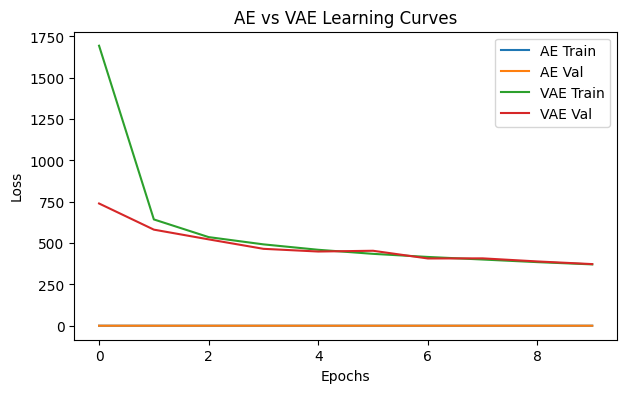

In [5]:
# ============================================================
# LEARNING CURVES
# ============================================================
plt.figure(figsize=(7,4))
plt.plot(ae_train, label="AE Train"); plt.plot(ae_val, label="AE Val")
plt.plot(vae_train, label="VAE Train"); plt.plot(vae_val, label="VAE Val")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("AE vs VAE Learning Curves")
plt.legend(); plt.show()

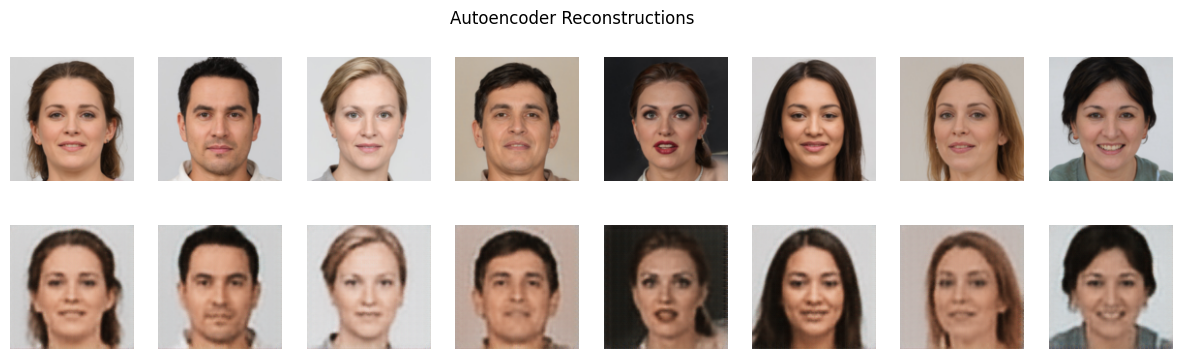

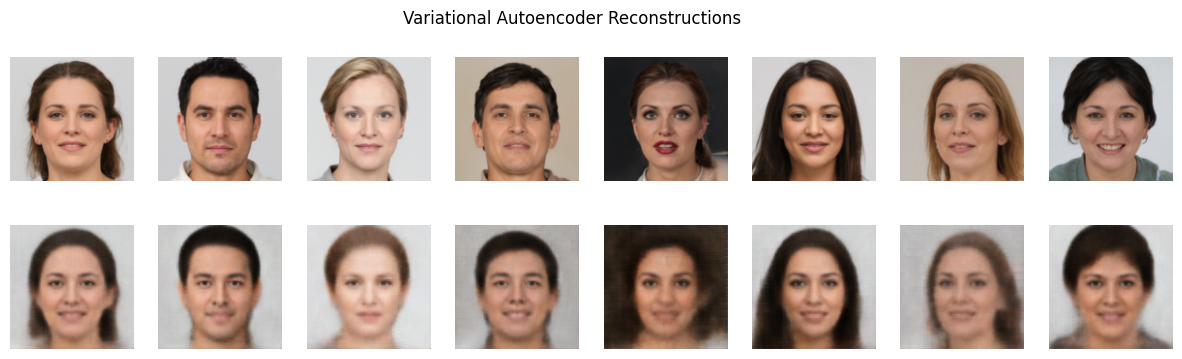

In [ ]:
# ============================================================
# RECONSTRUCTIONS
# ============================================================
model_list = [("Autoencoder", ae), ("Variational Autoencoder", vae)]

for name, model in model_list:
    model.eval()
    with torch.no_grad():
        imgs,_ = next(iter(test_loader))
        imgs = imgs[:8].to(device)
        if isinstance(model, VAE):
            recon,_,_ = model(imgs)
        else:
            recon = model(imgs)
        imgs, recon = imgs.cpu(), recon.cpu()

    fig, axes = plt.subplots(2,8, figsize=(15,4))
    for i in range(8):
        axes[0,i].imshow(np.transpose(imgs[i], (1,2,0))); axes[0,i].axis("off")
        axes[1,i].imshow(np.transpose(recon[i], (1,2,0))); axes[1,i].axis("off")
    axes[0,0].set_ylabel("Original"); axes[1,0].set_ylabel(name)
    plt.suptitle(name + " Reconstructions")
    #plt.savefig(name+"VAEvsAEreconstruction.pdf", bbox_inches="tight", pad_inches=0)
    plt.show()

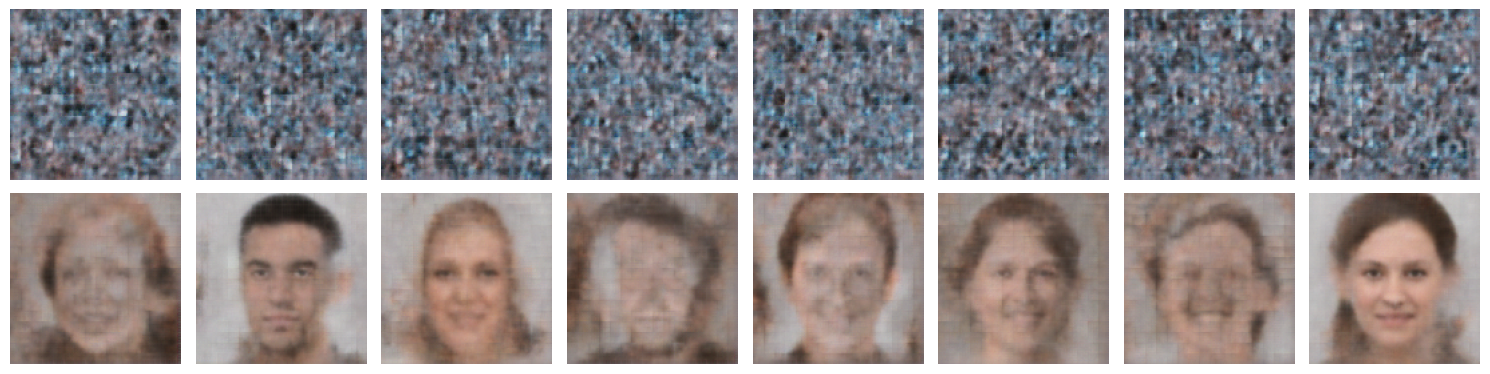

In [ ]:
# ============================================================
# RANDOM LATENT SAMPLES: AE vs VAE
# ============================================================
with torch.no_grad():
    # --- VAE: sample from N(0, I) in latent space ---
    z_vae = torch.randn(8, config["latent_dim"]).to(device)
    vae_samples = vae.decode(z_vae).cpu()

    # --- AE: random latent tensor (same shape as encoder output) ---
    z_ae = torch.randn(8, 128, config["image_size"] // 8, config["image_size"] // 8).to(device)
    ae_samples = ae.decoder(z_ae).cpu()

# ---- Plot both ----
fig, axes = plt.subplots(2, 8, figsize=(15, 4))

for i in range(8):
    axes[0, i].imshow(np.transpose(ae_samples[i], (1, 2, 0)))
    axes[0, i].axis("off")
    axes[1, i].imshow(np.transpose(vae_samples[i], (1, 2, 0)))
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("AE", fontsize=12)
axes[1, 0].set_ylabel("VAE", fontsize=12)
#plt.suptitle("Random Latent Samples: AE vs VAE")
plt.tight_layout()
#plt.savefig("VAEvsAEreconstructionRandomz.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

AE Iter 1/800 | Loss 1.172524e-03
AE Iter 200/800 | Loss 1.161768e-05
AE Iter 400/800 | Loss 2.257747e-06
AE Iter 600/800 | Loss 8.174230e-07
AE Iter 800/800 | Loss 3.868381e-07
VAE Iter 1/800 | Loss 6.337109e-04
VAE Iter 200/800 | Loss 3.735721e-05
VAE Iter 400/800 | Loss 2.388013e-05
VAE Iter 600/800 | Loss 1.922723e-05
VAE Iter 800/800 | Loss 1.650218e-05


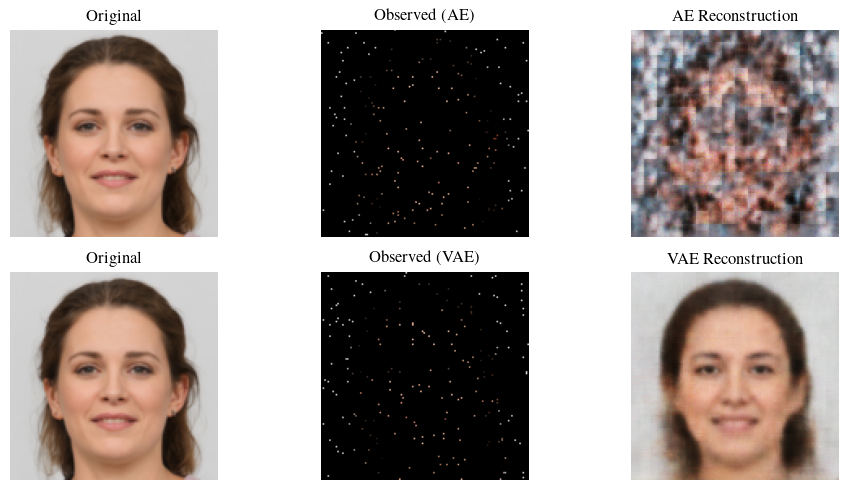

In [ ]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "text.latex.preamble": r"\usepackage{amsmath}",  # <-- add this
})
# ============================================================
# SPARSE MEASUREMENT RECONSTRUCTION (AE vs VAE)
# ============================================================
def sparse_reconstruction(model, is_vae=False, n_samples=5000, n_iters=800, lr=1e-2):
    model.eval()
    with torch.no_grad():
        test_imgs,_ = next(iter(test_loader))
    test_img = test_imgs[0:1].to(device)
    img_size = config["image_size"]

    # --- create 2D sampling mask ---
    mask2d = torch.zeros((1,1,img_size,img_size), device=device)
    xy_idx = torch.randint(0, img_size*img_size, (n_samples,), device=device)
    mask2d.view(-1)[xy_idx] = 1.0
    mask = mask2d.repeat(1,3,1,1)
    measured = test_img * mask

    # --- latent initialization ---
    if is_vae:
        latent_dim = config["latent_dim"]
        z = torch.randn(1, latent_dim, device=device, requires_grad=True)
    else:
        with torch.no_grad():
            dummy = torch.randn_like(test_img)
            z = model.encoder(dummy)
        z = torch.randn_like(z).to(device).requires_grad_(True)

    optimizer_z = optim.Adam([z], lr=lr)
    loss_fn = nn.MSELoss()

    # --- optimize latent code ---
    for i in range(n_iters):
        optimizer_z.zero_grad()
        if is_vae:
            recon = model.decode(z)
        else:
            recon = model.decoder(z)
        loss = loss_fn(recon * mask, measured)
        loss.backward()
        optimizer_z.step()
        if (i+1)%200==0 or i==0:
            print(f"{'VAE' if is_vae else 'AE'} Iter {i+1}/{n_iters} | Loss {loss.item():.6e}")

    with torch.no_grad():
        if is_vae:
            recon_img = model.decode(z).cpu().squeeze(0)
        else:
            recon_img = model.decoder(z).cpu().squeeze(0)
        sparse_obs = measured.cpu().squeeze(0)
        orig = test_img.cpu().squeeze(0)
    return orig, sparse_obs, recon_img

# ---- Run sparse reconstruction for AE and VAE ----
orig_ae, obs_ae, recon_ae = sparse_reconstruction(ae, is_vae=False, n_samples=200)
orig_vae, obs_vae, recon_vae = sparse_reconstruction(vae, is_vae=True, n_samples=200)

# ---- Visualization ----
def to_img(t): return np.transpose(t.numpy(), (1,2,0))
fig, axes = plt.subplots(2, 3, figsize=(10,5))
axes[0,0].imshow(to_img(orig_ae));  axes[0,0].set_title("Original");  axes[0,0].axis("off")
axes[0,1].imshow(to_img(obs_ae));   axes[0,1].set_title("Observed (AE)"); axes[0,1].axis("off")
axes[0,2].imshow(to_img(recon_ae)); axes[0,2].set_title("AE Reconstruction"); axes[0,2].axis("off")

axes[1,0].imshow(to_img(orig_vae));  axes[1,0].set_title("Original");  axes[1,0].axis("off")
axes[1,1].imshow(to_img(obs_vae));   axes[1,1].set_title("Observed (VAE)"); axes[1,1].axis("off")
axes[1,2].imshow(to_img(recon_vae)); axes[1,2].set_title("VAE Reconstruction"); axes[1,2].axis("off")

#plt.suptitle("Sparse Measurement Reconstruction (n=2000 pixels)")
#plt.savefig("VAEvsAEreconstruction200.pdf", bbox_inches="tight", pad_inches=0)
plt.tight_layout(); plt.show()